In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from RNN.models import EncoderDecoderGRU
from utils import (
    profile_predict,
    plot_profile,
    plot_prediction,
    perform_multiple_predictions,
)

In [15]:
curve_dir = {}
curve_dir[1] = (
    "/home/mazin/Projects/Thesis/Data/battery_model_paper/positive_discharge_20/149/1/1_4_0_0.csv"
)
curve_dir[2] = (
    "/home/mazin/Projects/Thesis/Data/battery_model_paper/positive_discharge_20/149/2/2_4_0_0.csv"
)
curve_dir[3] = (
    "/home/mazin/Projects/Thesis/Data/battery_model_paper/positive_discharge_20/149/3/3_4_0_0.csv"
)
curve_dir[4] = (
    "/home/mazin/Projects/Thesis/Data/battery_model_paper/positive_discharge_20/149/4/4_4_0_0.csv"
)
curve_dir[5] = (
    "/home/mazin/Projects/Thesis/Data/battery_model_paper/positive_discharge_20/149/5/5_4_0_0.csv"
)
curve_dir[6] = (
    "/home/mazin/Projects/Thesis/Data/battery_model_paper/positive_discharge_20/149/6/6_4_0_0.csv"
)
pretrained_weights = "/home/mazin/Projects/Thesis/RNN/checkpoints/polar-sky-201/SEFD-monitor_val-epoch=857-train_loss=0.0000321-val_loss=0.0001363-val_mae=0.01209.ckpt"  # Best Checkpoint
# pretrained_weights = "/home/mazin/Projects/Thesis/RNN/checkpoints/polar-sky-201/SEFD-monitor_val-epoch=629-train_loss=0.0000513-val_loss=0.0004591-val_mae=0.02010.ckpt"  # For comparison with Dynaformer
# pretrained_weights = "/home/mazin/Projects/Thesis/RNN/outputs/2024-06-12/15-08-06/weights/avid-sea-233-epoch=40-train_loss=0.0000056-val_loss=0.0001128-val_mae=0.01011.ckpt"
encoder_input_length = 20
decoder_input_length = 1980
current_min = -2.5
current_max = 1
voltage_min = 2.5
voltage_max = 4.2

In [16]:
model = EncoderDecoderGRU.load_from_checkpoint(pretrained_weights).to("cpu")

### Verify/Test the Model Checkpoint

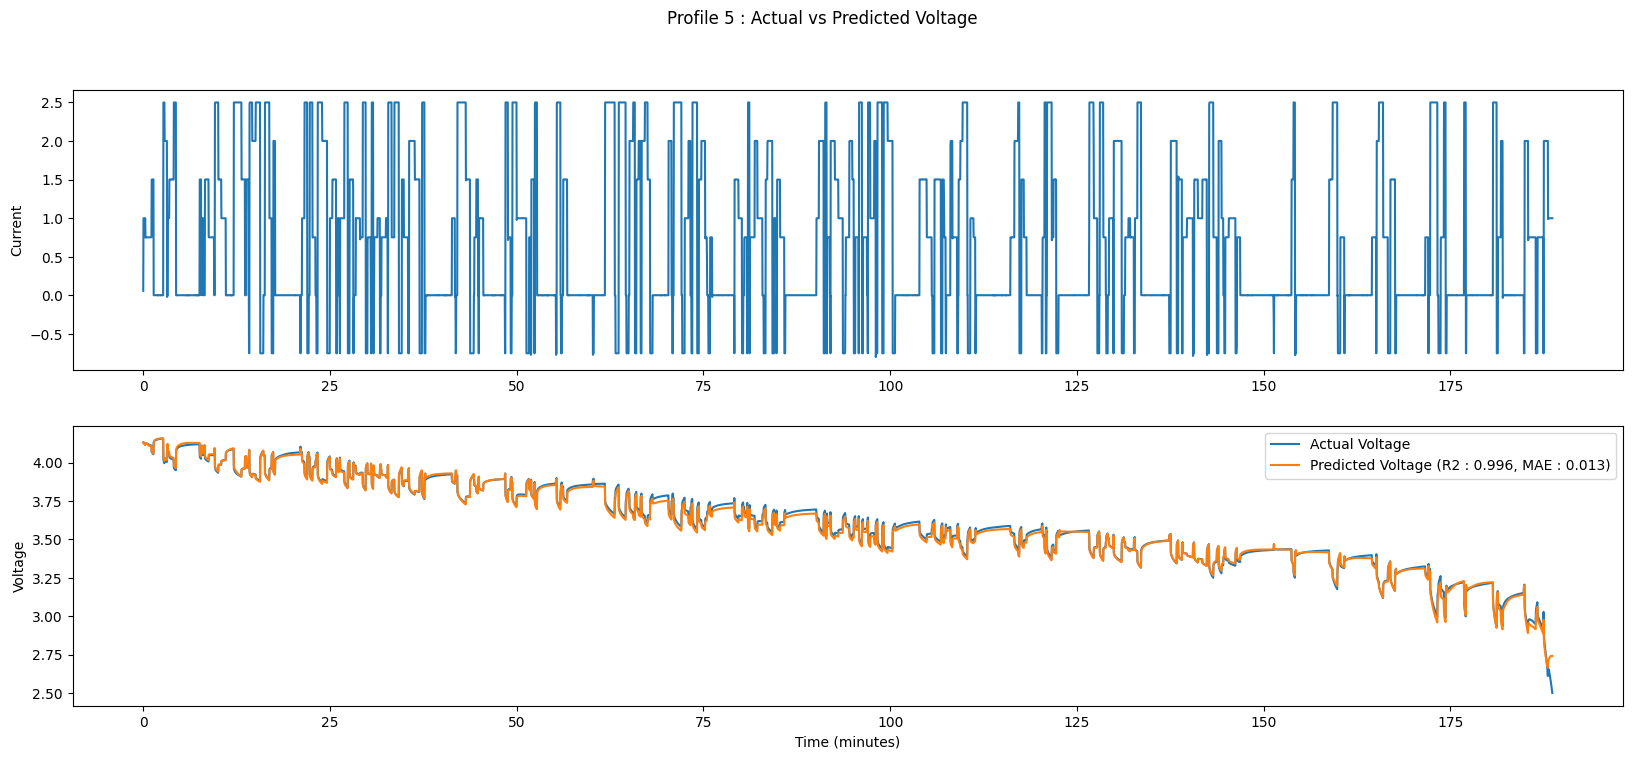

In [18]:
profile = np.random.choice(list(curve_dir.keys()))
actual_current, actual_voltage, predicted_voltage = profile_predict(
    model, curve_dir[profile]
)
plot_profile(
    actual_current,
    actual_voltage,
    predicted_voltage,
    title=f"Profile {profile} : Actual vs Predicted Voltage",
)

### Plot Behavior at Rest

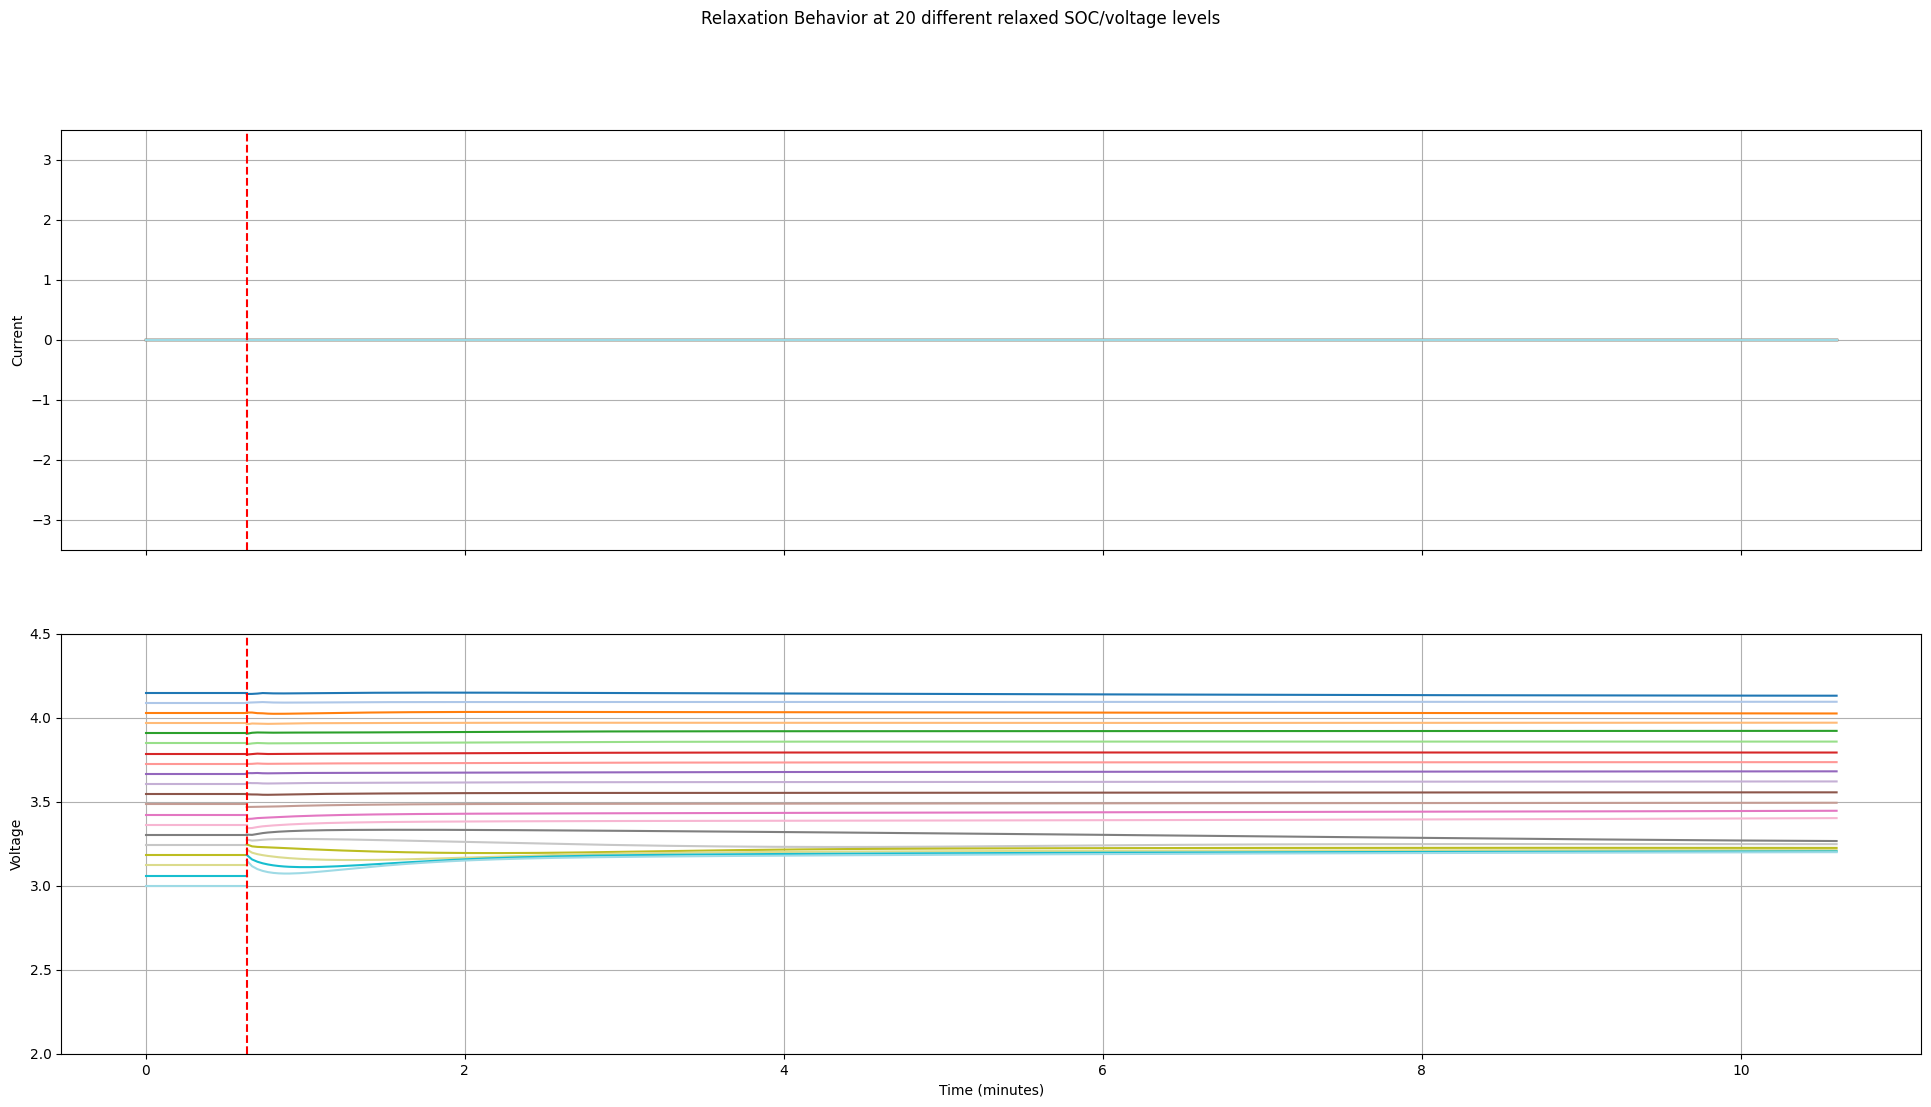

In [19]:
num_predictions = 20
encoder_current_values = [
    0
] * num_predictions  # Replace with your list of encoder current values
encoder_voltage_values = np.linspace(
    4.15, 3, num_predictions
)  # Adjust voltage levels accordingly
decoder_current_values = [
    0
] * num_predictions  # Replace with your list of decoder current values

encoder_current, decoder_current, encoder_voltage, predicted_voltage = (
    perform_multiple_predictions(
        model,
        encoder_current_values,
        encoder_voltage_values,
        decoder_current_values,
        decoder_input_length=300,
    )
)

plot_prediction(
    encoder_current,
    decoder_current,
    encoder_voltage,
    predicted_voltage,
    title=f"Relaxation Behavior at {num_predictions} different relaxed SOC/voltage levels",
)

### Quantify the error

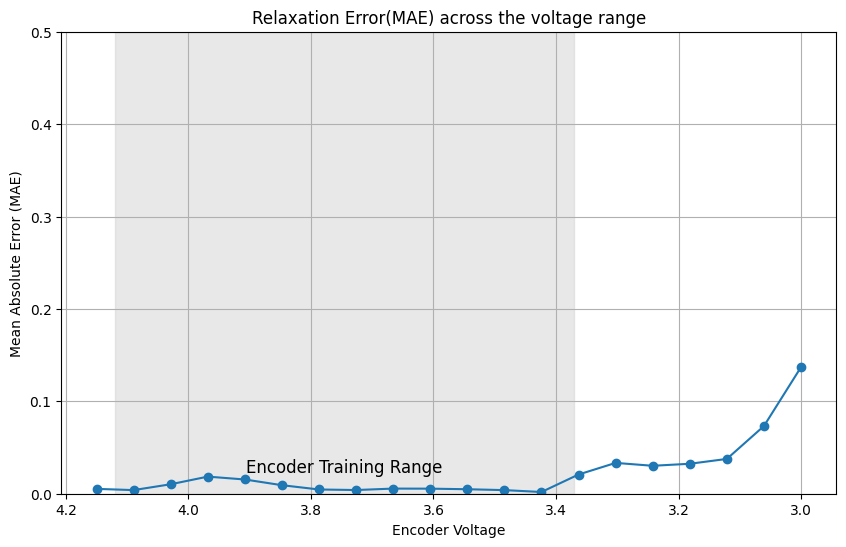

In [14]:
# Compute MAE for each pair of encoder_voltage and predicted_voltage
mae_values = []
for encoder_voltage_element, predicted_voltage_element in zip(
    encoder_voltage_values, predicted_voltage
):
    mae = mean_absolute_error(
        np.full_like(predicted_voltage_element, encoder_voltage_element),
        predicted_voltage_element,
    )
    mae_values.append(mae)

# Plot MAE values against encoder_voltage_values
plt.figure(figsize=(10, 6))
plt.plot(encoder_voltage_values, mae_values, marker="o", linestyle="-")
plt.ylim(0, 0.5)
plt.fill_betweenx(
    [0, 0.5], 4.12, 3.37, color="lightgray", alpha=0.5
)  # Shade the region from 4.12 to 3.37
plt.text(
    3.745, np.mean(mae_values), "Encoder Training Range", fontsize=12, ha="center"
)  # Add text annotation for the shaded area
plt.xlabel("Encoder Voltage")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Relaxation Error(MAE) across the voltage range")
plt.grid(True)
plt.gca().invert_xaxis()  # Invert x-axis
plt.show()